In [1]:
#!pip install git+https://github.com/bancaditalia/black-it.git#egg=black-it

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path += ["/home/jacopo.lenti/Projects/learning-od-step-by-step/src"]
import simulator_BC as sim_bc
import estimation_epsilon_BC as est_bc
from calibrator_blackit import Calibrator #i just commented few lines of code to remove the output print
#from black_it.calibrator import Calibrator
import pandas as pd
from black_it.samplers.halton import HaltonSampler
from black_it.samplers.random_forest import RandomForestSampler
from black_it.samplers.best_batch import BestBatchSampler
from black_it.loss_functions.msm import MethodOfMomentsLoss
from black_it.samplers.random_uniform import RandomUniformSampler
from typing import Sequence
import os
import contextlib
from scipy.special import expit
import torch
import importlib
from time import time

In [2]:
importlib.reload(sim_bc)
importlib.reload(est_bc)

<module 'estimation_epsilon_BC' from '/home/jacopo.lenti/Projects/learning-od-step-by-step/src/estimation_epsilon_BC.py'>

In [3]:
batch_size = 6

random_sampler = RandomUniformSampler(batch_size)
all_samplers = [HaltonSampler, RandomForestSampler, BestBatchSampler]

loss = MethodOfMomentsLoss()

## AR1
Firstly, try calibration with a very simple model.

In [4]:
def AR1_model_one_parameter(beta1: float, N, seed = 0):
    np.random.seed(seed = seed)

    x = np.zeros(N)
    x[0] = 0

    for t in range(1, N):
        x[t] = beta1 * x[t-1] + np.random.normal(0, 0.05)

    return np.atleast_2d(x).T

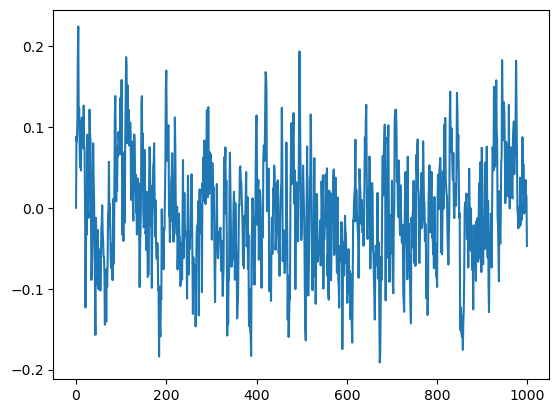

In [5]:
beta1 = 0.7

target_series = AR1_model_one_parameter(beta1, 1000)

beta_bounds = [[0], [1]]
precisions = [0.0001]

plt.plot(target_series)


In [6]:
AR1_cal = Calibrator(real_data = target_series, 
                     samplers = [HaltonSampler(batch_size)],
                     loss_function = loss,
                     model= AR1_model_one_parameter, 
                     parameters_bounds = beta_bounds,
                     parameters_precision = precisions,
                     ensemble_size = 3,
                     verbose = False,
                     saving_folder = None#'initial_state'
                )
    

In [7]:
betasAR1_cal, lossAR1_cal = AR1_cal.calibrate(100)

#### MSM Loss function

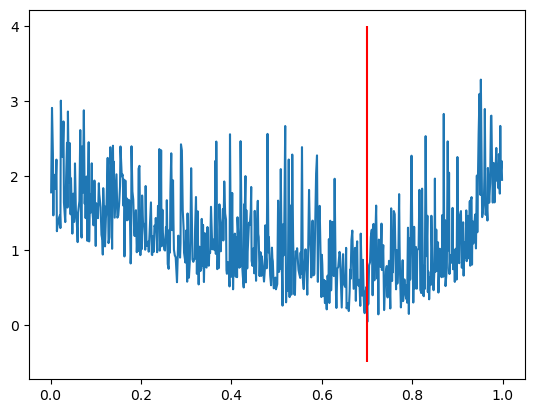

In [10]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.plot(pd.DataFrame([betasAR1_cal[:,0], lossAR1_cal]).T.rename(columns = {0: "epsilon", 1: "loss"}).sort_values("epsilon").set_index("epsilon"))
ax.vlines(x = beta1, ymin = -0.5, ymax = 4, colors = "red")

In [210]:
pd.DataFrame([{"beta": betasAR1_cal[k,0], "loss": lossAR1_cal[k]} for k in range(len(lossAR1_cal))]).sort_values("loss").set_index("beta").head()


,loss
beta,
0.7006,0.044593
0.7250,0.144515
0.7924,0.150312
0.6947,0.160649
0.6596,0.188519


## Stochastic BC
**Idea**: to compare calibration with PGABM, we need to give them the same information. In the simplest case, they require X, edges, and $\mu$ and input to estimate $\epsilon$. 
To use all these information, we assume that the calibrator simulate edges[u,v,s,t] | X[t], u,v.
It estimates $\epsilon$ comparing s_pred with s, the list of signs from the simulated and real time series.


In [214]:
#this function return the simulated list of edges, from X, edges, and epsilon
#it simulated edges[t]|X[t],u,v
#so it knows the picked nodes and their opinions
def simulate(X, edges, epsilon, rho = 100, seed = 1):
    edges_pred = edges.clone()
    
    np.random.seed(seed)
    
    T, edge_per_t, _ = edges.size()
    
    for t in range(T - 1):
        for new_edge in range(edge_per_t):

            u,v,s = edges[t, new_edge]
            dist = np.abs(X[t, u] - X[t, v])

            if np.random.random() < expit(rho * (epsilon - dist)):
                edges_pred[t][new_edge][2] = torch.tensor(1)
            else:
                edges_pred[t][new_edge][2] = torch.tensor(0)
                

    return edges_pred

In [281]:
#define a simulator class for simulating the BC model knowing the real edges and opinions
#the calibration will compare the arrays of signs: self.s and simulate_s([epsilon])
#i input theta = [epsilon], instead of epsilon, because the Calibrator of black-it is designed for calibrating a list of parameters
class BC_simulator_given_previous_time():
    def __init__(self, X, edges, mu, real_epsilon, rho = 100, seed = 1):
        self.X = X
        self.edges = edges
        self.mu = mu
        self.real_epsilon = real_epsilon
        self.rho = rho
        self.seed = seed
        self.s = np.concatenate(np.array(edges[:,:,2]))[:, None] #Calibrator requires a time series of dim N, n_of_parameters
        self.mean_s = np.array(edges[:,:,2]).mean(axis = 1)[:,None]
    
    def simulate_s(self, theta, T = 200, seed = None):
        epsilon, = theta
        
        s_pred = np.array([])
        
        if seed != None:
            np.random.seed(self.seed)
        
        T, edge_per_t, _ = self.edges.size()
        
        for t in range(T):
            for new_edge in range(edge_per_t):
                
                u,v,s = self.edges[t, new_edge]
                dist = np.abs(self.X[t, u] - self.X[t, v])
                
                if np.random.random() < expit(self.rho * (epsilon - dist)):
                    s_pred = np.append(s_pred, 1)
                else:
                    s_pred = np.append(s_pred, 0)
        
        
        return s_pred[:, None] #Calibrator requires a time series of dim N, n_of_parameters
    
    def simulate_mean_s(self, theta, T = 200, seed = None):
        epsilon, = theta
        
        mean_s_pred = np.array([])
        
        if seed != None:
            np.random.seed(self.seed)
        
        T, edge_per_t, _ = self.edges.size()
        
        for t in range(T):
            s_t = np.array([])
            for new_edge in range(edge_per_t):
                
                u,v,s = self.edges[t, new_edge]
                dist = np.abs(self.X[t, u] - self.X[t, v])
                
                if np.random.random() < expit(self.rho * (epsilon - dist)):
                    s_t = np.append(s_t, 1)
                else:
                    s_t = np.append(s_t, 0)
                    
            mean_s_pred = np.append(mean_s_pred, np.mean(s_t))
        
        
        return mean_s_pred[:, None] #Calibrator requires a time series of dim N, n_of_parameters

In [292]:
N, T, edge_per_t = 100, 400, 3

epsilon, mu = 0.22, 0.6

epsilon_bounds = [[0.], [1.]]
precisions = [0.0001]

In [293]:
X, edges = sim_bc.simulator_stoch(N, T, edge_per_t, epsilon, mu, seed = 1004, steepness = 100)
s_edges = np.concatenate(np.array(edges[:,:,2]))

simulator_BC = BC_simulator_given_previous_time(X, edges, mu, epsilon)

In [294]:
s_pred = simulator_BC.simulate_s([0.55])

In [295]:
print("Same interaction sign", np.sum(np.abs(s_edges - (1 - s_pred))))
print("Different interaction sign", np.sum(np.abs(s_edges - s_pred)))

Same interaction sign 659572.0
Different interaction sign 773237.0


In [296]:
BC_cal = Calibrator(real_data = simulator_BC.s, 
                    samplers = [HaltonSampler(batch_size)],
                    loss_function = loss,
                    model = simulator_BC.simulate_s, 
                    parameters_bounds = epsilon_bounds,
                    parameters_precision = precisions,
                    ensemble_size = 3,
                    saving_folder = None,
                    verbose = False,
                    n_jobs = 1#'initial_state'
                   )

In [297]:
epsilon_BCcal, loss_BCcal = BC_cal.calibrate(100)

/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/black_it/utils/time_series.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  s, k = skew(time_series), kurtosis(time_series)  # pylint: disable=invalid-name
/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


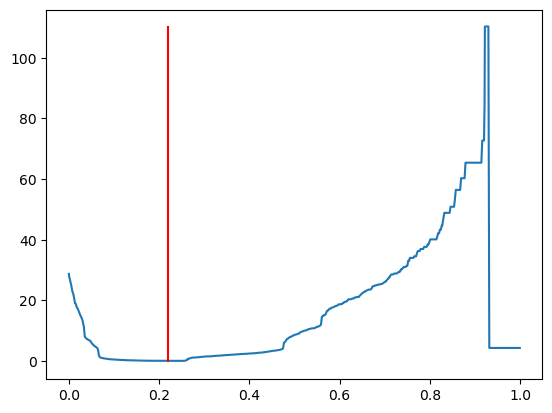

In [298]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.plot(pd.DataFrame([epsilon_BCcal[:,0], loss_BCcal]).T.rename(columns = {0: "epsilon", 1: "loss"}).sort_values("epsilon").set_index("epsilon"))
ax.vlines(x = epsilon, ymin = -0.5, ymax = loss_BCcal.max(), colors = "red")


In [299]:
def define_calibrator_BC(simulator_BC, samplers = [HaltonSampler(batch_size)], loss = MethodOfMomentsLoss(),
                         epsilon_bounds = [[0.], [1.]],precisions = [0.0001]):
    BC_cal = Calibrator(real_data = simulator_BC.s, 
                        samplers = [HaltonSampler(batch_size)],
                        loss_function = loss,
                        model = simulator_BC.simulate_s,
                        parameters_bounds = epsilon_bounds,
                        parameters_precision = precisions,
                        ensemble_size = 3,
                        saving_folder = None,
                        verbose = False,
                        n_jobs = 1#'initial_state'
                       )
    return BC_cal

def calibrate_epsilon_BC(simulator_BC, plot_loss = True, precisions = [0.0001], calibration_batches = 100):
    BC_cal = define_calibrator_BC(simulator_BC)
    
    epsilon_BCcal, loss_BCcal = BC_cal.calibrate(calibration_batches)
    loss_epsilon_df = pd.DataFrame([{"epsilon": epsilon_BCcal[k,0], "loss": loss_BCcal[k]} for k in range(len(loss_BCcal))]).sort_values("epsilon").set_index("epsilon")
    
    
    if plot_loss:
        fig, ax = plt.subplots(nrows = 1, ncols = 1)
        ax.plot(loss_epsilon_df)
        ax.vlines(x = simulator_BC.real_epsilon, ymin = -0.5, ymax = loss_epsilon_df.max(), colors = "red")

    estimated_epsilon = loss_epsilon_df.sort_values("loss").index[0]
    return loss_epsilon_df, estimated_epsilon
        
    
    
    

/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/black_it/utils/time_series.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  s, k = skew(time_series), kurtosis(time_series)  # pylint: disable=invalid-name
/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


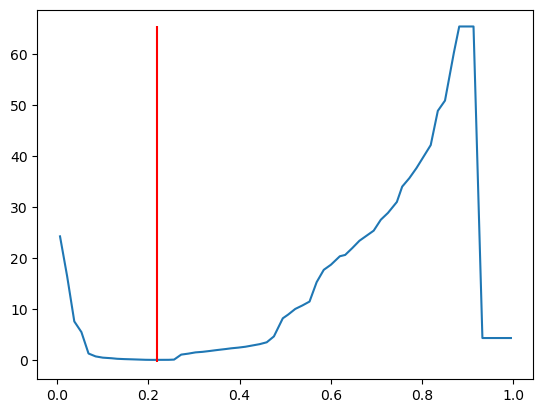

In [300]:
loss_epsilon_df, estimated_epsilon = calibrate_epsilon_BC(simulator_BC, plot_loss = True, precisions = [0.0001], calibration_batches = 10)


In [301]:
def PGABM_vs_calibration(N, T, edge_per_t, epsilon, mu, epsilon0 = 0.2, rho = 100, plot_loss_calibration = True, plot_epsilon_pgabm = True,
                         precisions = [0.0001], calibration_batches = 100, num_epochs = 1000, seed = None):
    X, edges = sim_bc.simulator_stoch(N, T, edge_per_t, epsilon, mu, rho, seed)
    simulator_BC = BC_simulator_given_previous_time(X, edges, mu, epsilon, rho, seed)
    
    t0 = time()
    loss_epsilon_df, estimated_epsilon = calibrate_epsilon_BC(simulator_BC, plot_epsilon_pgabm, precisions, calibration_batches)
    t1 = time()
    history_torch = est_bc.estimation_epsilon_torch(rho, mu, X, edges, epsilon0, num_epochs)
    t2 = time()
    
    if plot_epsilon_pgabm:
        fig, ax = plt.subplots(nrows = 1, ncols = 1)
        ax.plot(history_torch["epsilon"])
        ax.hlines(y = epsilon, xmin = -0.5, xmax = num_epochs, colors = "red")
        
        fig.show()
    

    calibration_epsilon = loss_epsilon_df.sort_values("loss").index[0]
    pgabm_epsilon = history_torch["epsilon"][-1]
    return calibration_epsilon, pgabm_epsilon, loss_epsilon_df, history_torch, t1-t0, t2-t1


In [303]:
N, T, edge_per_t = 200, 100, 5
epsilon, mu, epsilon0 = 0.13, 0.6, 0.05

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 3335.13it/s]


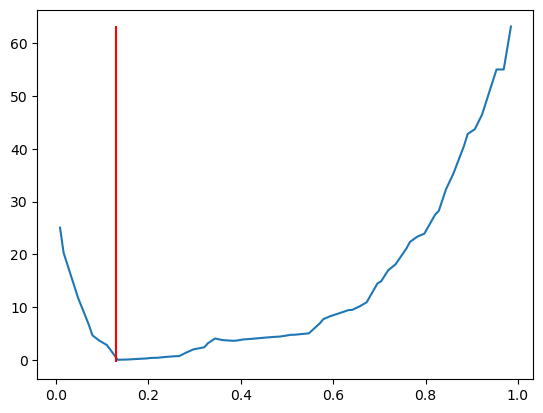

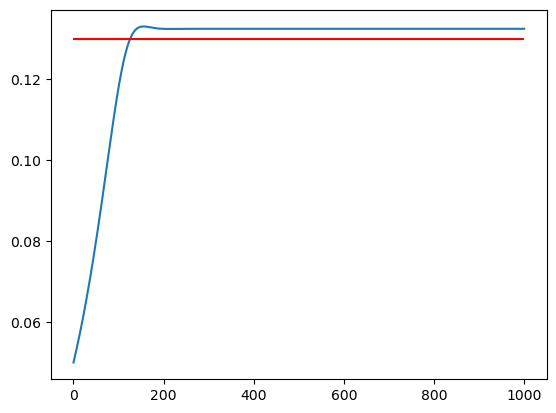

In [304]:
calibration_epsilon, pgabm_epsilon, loss_epsilon_df, history_torch, t_cal, t_pgabm = PGABM_vs_calibration(N, T, edge_per_t, epsilon, mu,
                                                                      epsilon0, rho = 100, 
                                                                      plot_loss_calibration = True, plot_epsilon_pgabm = True, precisions = [0.0001], 
                                                                      calibration_batches = 10, num_epochs = 1000)


In [305]:
t_cal, t_pgabm

(5.501439571380615, 0.3141512870788574)

In [306]:
loss_epsilon_df.sort_values("loss").index[0], history_torch["epsilon"][-1]

(0.13340000000000002, 0.13250138231700243)

### Aggregating the edges

In [308]:
N, T, edge_per_t = 100, 400, 3

epsilon, mu = 0.15, 0.2

epsilon_bounds = [[0.], [1.]]
precisions = [0.0001]

In [309]:
X, edges = sim_bc.simulator_stoch(N, T, edge_per_t, epsilon, mu, seed = 1004, steepness = 100)
s_edges = np.concatenate(np.array(edges[:,:,2]))

simulator_BC = BC_simulator_given_previous_time(X, edges, mu, epsilon)

In [310]:
mean_s_pred = simulator_BC.simulate_mean_s([0.45])

In [311]:
np.sum(np.abs(mean_s_pred - simulator_BC.mean_s))

186.0

In [312]:
BC_cal = Calibrator(real_data = simulator_BC.mean_s, 
                    samplers = [HaltonSampler(batch_size)],
                    loss_function = loss,
                    model = simulator_BC.simulate_mean_s, 
                    parameters_bounds = epsilon_bounds,
                    parameters_precision = precisions,
                    ensemble_size = 3,
                    saving_folder = None,
                    verbose = False,
                    n_jobs = 1#'initial_state'
                   )

In [313]:
epsilon_BCcal, loss_BCcal = BC_cal.calibrate(100)

/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/black_it/utils/time_series.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  s, k = skew(time_series), kurtosis(time_series)  # pylint: disable=invalid-name
/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


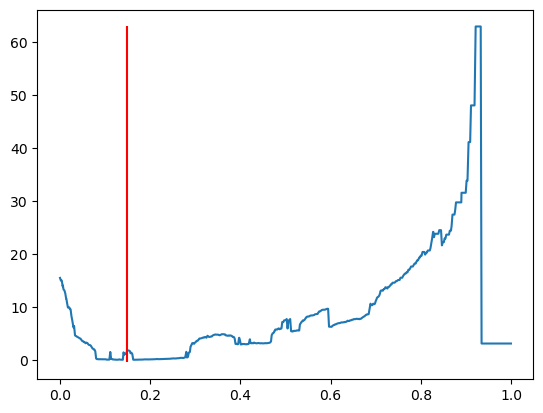

In [314]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.plot(pd.DataFrame([epsilon_BCcal[:,0], loss_BCcal]).T.rename(columns = {0: "epsilon", 1: "loss"}).sort_values("epsilon").set_index("epsilon"))
ax.vlines(x = epsilon, ymin = -0.5, ymax = loss_BCcal.max(), colors = "red")


In [315]:
pd.DataFrame([epsilon_BCcal[:,0], loss_BCcal]).T.rename(columns = {0: "epsilon", 1: "loss"}).sort_values("loss").set_index("epsilon")

,loss
epsilon,
0.1647,0.011630
0.1398,0.013004
0.1393,0.013224
0.1276,0.013341
0.1633,0.015585
...,...
0.9264,62.893307
0.9225,62.893307
0.9303,62.893307
